In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm 

In [2]:
df = pd.read_csv('cleaned_hospital.csv')

## Next Step: Decision Tree Regressor

A Decision Tree Regressor is a natural next step because:
- **Non-linear modeling:** It can automatically capture complex, non-linear patterns without feature engineering.
- **Flexibility:** It partitions the feature space into regions, adapting to different hospital, DRG, and severity subgroups.
- **Interpretability:** Trees provide clear rules for how features impact cost.
- **Ease of use:** No need for feature scaling or normalization.

Thus, moving to a decision tree model can better capture the segmented and non-linear structure of the data, particularly improving predictions for high-cost cases where the linear model underperformed.

In [ ]:
# Prepare feature set
feature_cols = ['Year', 'Facility Id', 'APR DRG Code', 'APR Severity of Illness Code', 'APR Medical Surgical Code']
X = df[feature_cols]
y = df['log_mean_cost']

# One-hot encode categorical features
X = pd.get_dummies(X, columns=['Facility Id', 'APR DRG Code', 'APR Medical Surgical Code'])

# Initialize model and cross-validator
dt_model = DecisionTreeRegressor(
    max_depth=12,
    min_samples_leaf=500,
    random_state=42
)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics
rmse_log_list, mae_log_list, r2_log_list = [], [], []
rmse_original_list, mae_original_list, r2_original_list = [], [], []
fold_results = []

print("5-Fold Cross Validation...")
print("=" * 80)

for fold, (train_idx, val_idx) in enumerate(tqdm(kf.split(X), total=5), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    dt_model.fit(X_train, y_train)

    y_val_pred_log = dt_model.predict(X_val)

    # Log scale metrics
    mse_log = mean_squared_error(y_val, y_val_pred_log)
    rmse_log = np.sqrt(mse_log)
    mae_log = mean_absolute_error(y_val, y_val_pred_log)
    r2_log = r2_score(y_val, y_val_pred_log)

    rmse_log_list.append(rmse_log)
    mae_log_list.append(mae_log)
    r2_log_list.append(r2_log)

    # Original scale metrics
    y_val_pred_original = np.expm1(y_val_pred_log)
    y_val_original = np.expm1(y_val)

    mse_original = mean_squared_error(y_val_original, y_val_pred_original)
    rmse_original = np.sqrt(mse_original)
    mae_original = mean_absolute_error(y_val_original, y_val_pred_original)
    r2_original = r2_score(y_val_original, y_val_pred_original)

    rmse_original_list.append(rmse_original)
    mae_original_list.append(mae_original)
    r2_original_list.append(r2_original)

    fold_results.append({
        'Fold': fold,
        'RMSE (log)': rmse_log,
        'MAE (log)': mae_log,
        'R² (log)': r2_log,
        'RMSE (original)': rmse_original,
        'MAE (original)': mae_original,
        'R² (original)': r2_original
    })

# Create and print Fold Result Table
results_df = pd.DataFrame(fold_results)

results_df_rounded = results_df.round({
    'RMSE (log)': 4,
    'MAE (log)': 4,
    'R² (log)': 4,
    'RMSE (original)': 2,
    'MAE (original)': 2,
    'R² (original)': 4
})

## Decision Tree Performance Summary

In [4]:
print("\nCross-Validation Fold Results:")
print("=" * 80)
print(results_df_rounded)

# Print overall mean ± std
print("\nOverall Cross-Validation Summary:")
print("=" * 80)
print("(log scale):")
print(f"Mean RMSE: {np.mean(rmse_log_list):.4f} ± {np.std(rmse_log_list):.4f}")
print(f"Mean MAE: {np.mean(mae_log_list):.4f} ± {np.std(mae_log_list):.4f}")
print(f"Mean R²: {np.mean(r2_log_list):.4f} ± {np.std(r2_log_list):.4f}")
print("-" * 80)
print("(original scale):")
print(f"Mean RMSE: {np.mean(rmse_original_list):.2f} ± {np.std(rmse_original_list):.2f}")
print(f"Mean MAE: {np.mean(mae_original_list):.2f} ± {np.std(mae_original_list):.2f}")
print(f"Mean R²: {np.mean(r2_original_list):.4f} ± {np.std(r2_original_list):.4f}")
print("=" * 80)


Cross-Validation Fold Results:
   Fold  RMSE (log)  MAE (log)  R² (log)  RMSE (original)  MAE (original)  \
0     1      0.7013     0.5243    0.4709         33440.34        10149.25   
1     2      0.7028     0.5248    0.4694         32757.15        10244.51   
2     3      0.7003     0.5230    0.4721         29014.97        10107.20   
3     4      0.7011     0.5236    0.4685         30829.98        10143.38   
4     5      0.6994     0.5224    0.4707         29894.14        10059.65   

   R² (original)  
0         0.1803  
1         0.1826  
2         0.2302  
3         0.2011  
4         0.2171  

Overall Cross-Validation Summary:
(log scale):
Mean RMSE: 0.7010 ± 0.0011
Mean MAE: 0.5236 ± 0.0008
Mean R²: 0.4703 ± 0.0012
--------------------------------------------------------------------------------
(original scale):
Mean RMSE: 31187.31 ± 1676.88
Mean MAE: 10140.80 ± 60.91
Mean R²: 0.2022 ± 0.0193


Across 5-fold cross-validation, the Decision Tree Regressor achieved:

- Mean R² ≈ 0.47 on the log(mean cost) scale
- Mean R² ≈ 0.20 on the original cost scale
- Average RMSE ≈ 31,000 on the original scale
- Average MAE ≈ 10,100 on the original scale

It's quite surprising that the decision tree model performs a lot worse than linear regression model. The Decision Tree captured some non-linear relationships but ignored the overall smooth trend of log mean costs.


## Feature Importance Graph Analysis

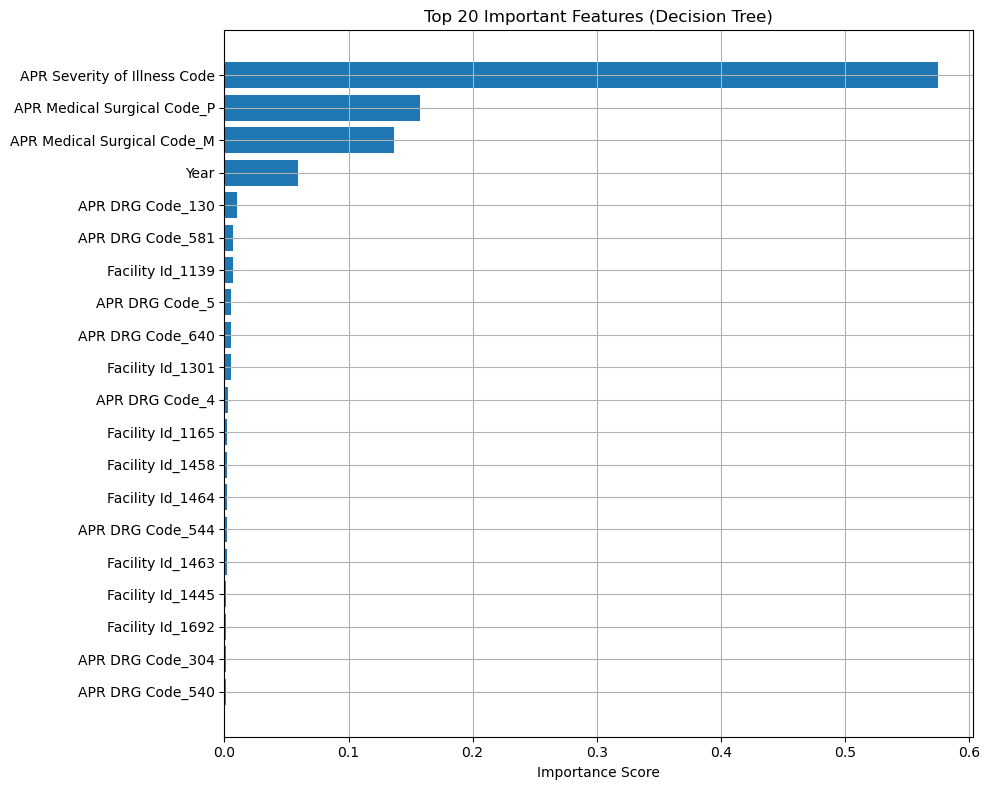

In [6]:
# Feature Importance Visualization
feature_importances = dt_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot top 20 features
top_n = 20
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'].iloc[:top_n][::-1], importance_df['Importance'].iloc[:top_n][::-1])
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Important Features (Decision Tree)')
plt.grid(True)
plt.tight_layout()
plt.show()

From the feature importance plot, we observe that the Decision Tree model heavily relies on a single feature ` APR Severity of Illness Code`. 

This suggests that the input features are too sparse and too weak, which makes the decision tree unable to make good use of information.

In next step, we want to try out models that randomly selected feature to avoid overfitting specific features

## Next Step: XGBoost